In [5]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
transform = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.MNIST (root = "./dataset", train = True, download = False, transform = transform)
test_set = torchvision.datasets.MNIST (root = "./dataset", train = False, download = False, transform = transform)

train_loader = torch.utils.data.DataLoader (train_set, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader (test_set, batch_size = 32, shuffle = False)

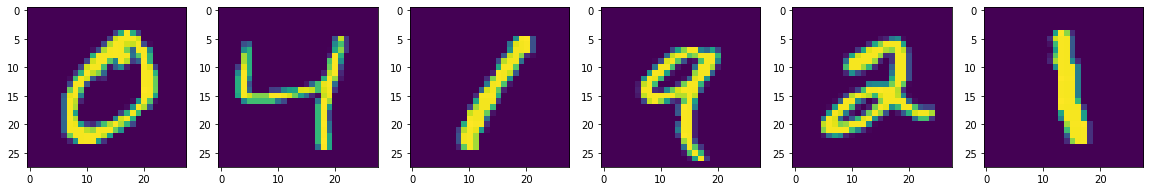

In [19]:
# visualize data
fig = plt.figure (figsize = (20, 20))
for i in range(1, 7):
    img = transforms.ToPILImage(mode='L')(train_set[i][0])
    fig.add_subplot(1, 6, i)
    plt.imshow(img)
plt.show()

In [20]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.linear_1 = nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = nn.Linear(128, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        
        x = x.reshape(x.size(0), -1)
        
        x = self.linear_1(x)
        x = self.relu(x)
        
        pred = self.linear_2(x)

        return pred

In [25]:
model = Model()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

In [26]:
model

Model(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=3136, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [28]:
train_loss = list()
val_loss = list()
gradien_vector = []

for epoch in range(epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_loader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = model(image)
        pred.to (device)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)
    
    print('\nEpoch: {}/{}, Train Loss: {:.8f}'.format(epoch + 1, epochs, total_train_loss))

    
    #Gradients
    g_2 = []
    for name, param in model.named_parameters():
        if param.requires_grad and "bias" not in name:
            #print (name, param.grad.data)
            g_2.append(torch.flatten(param.grad.data))
    print(torch.norm(torch.cat([g_2[0],g_2[1],g_2[2],g_2[3]],dim=0)))
    gradien_vector.append(torch.norm(torch.cat([g_2[0],g_2[1],g_2[2],g_2[3]],dim=0)).item())


Epoch: 1/100, Train Loss: 0.00323301
tensor(0.0001, device='cuda:0')

Epoch: 2/100, Train Loss: 0.00270235
tensor(3.7346e-06, device='cuda:0')

Epoch: 3/100, Train Loss: 0.00242468
tensor(4.8441e-05, device='cuda:0')

Epoch: 4/100, Train Loss: 0.00443033
tensor(0.0189, device='cuda:0')

Epoch: 5/100, Train Loss: 0.00228688
tensor(2.3863, device='cuda:0')

Epoch: 6/100, Train Loss: 0.00336253
tensor(1.3339e-05, device='cuda:0')

Epoch: 7/100, Train Loss: 0.00242932
tensor(1.7032e-05, device='cuda:0')

Epoch: 8/100, Train Loss: 0.00220884
tensor(0.0002, device='cuda:0')

Epoch: 9/100, Train Loss: 0.00254542
tensor(0.0002, device='cuda:0')

Epoch: 10/100, Train Loss: 0.00213662
tensor(0.0005, device='cuda:0')

Epoch: 11/100, Train Loss: 0.00212427
tensor(0.0017, device='cuda:0')

Epoch: 12/100, Train Loss: 0.00066435
tensor(0.0002, device='cuda:0')

Epoch: 13/100, Train Loss: 0.00519496
tensor(4.6814e-06, device='cuda:0')

Epoch: 14/100, Train Loss: 0.00162911
tensor(4.8397e-07, device='

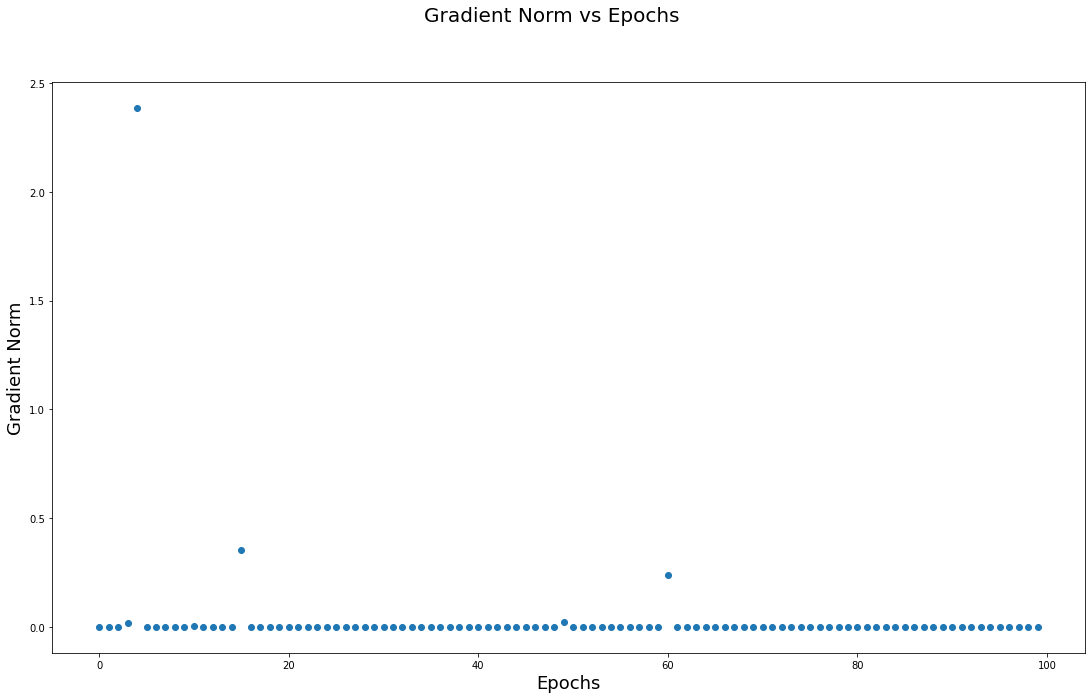

In [30]:
import numpy as np
x = np.arange(len(gradien_vector))
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Gradient Norm vs Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Gradient Norm', fontsize=18)
plt.scatter(x,gradien_vector)
plt.savefig('scatterplot_gradient norm vs epochs.pdf')